In [2]:
# ---------------- Download and Extract Kaggle Dataset ---------------- #
!pip install kaggle
!mkdir -p ~/.kaggle
!echo '{"username":"harshgupta21bce6101","key":"7b4970149b4ff86915e405bd4386b8cb"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip chest-xray-pneumonia.zip -d chest_xray

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/chest_xray/train

In [ ]:
import os
import random
import numpy as np
import tensorflow as tf
import hashlib
import time
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB1, ResNet50
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
import shutil

# ---------------- Corrected Dataset Path ---------------- #
dataset_path = "./chest_xray/chest_xray"
num_clients = 2

# ---------------- Distribute Data Among Clients ---------------- #
for client_id in range(num_clients):
    client_dir = os.path.join(dataset_path, f'client_{client_id}')
    os.makedirs(client_dir, exist_ok=True)
    for class_name in ['NORMAL', 'PNEUMONIA']:
        class_dir = os.path.join(client_dir, class_name)
        os.makedirs(class_dir, exist_ok=True)

for class_name in ['NORMAL', 'PNEUMONIA']:
    class_path = os.path.join(dataset_path, 'train', class_name)
    for i, filename in enumerate(os.listdir(class_path)):
        client_id = i % num_clients
        source_path = os.path.join(class_path, filename)
        dest_path = os.path.join(dataset_path, f'client_{client_id}', class_name, filename)
        shutil.copy(source_path, dest_path)

# ---------------- Load Client Data ---------------- #
def load_client_data(client_id, dataset_path):
    client_dir = os.path.join(dataset_path, f'client_{client_id}')
    train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

    train_dataset = train_datagen.flow_from_directory(
        client_dir, target_size=(240, 240), batch_size=16, class_mode='categorical', subset='training')
    val_dataset = train_datagen.flow_from_directory(
        client_dir, target_size=(240, 240), batch_size=16, class_mode='categorical', subset='validation')

    num_classes = len(train_dataset.class_indices)
    return train_dataset, val_dataset, num_classes

# ---------------- Optimized Client Selection Strategy ---------------- #
def select_clients(num_clients, fraction=0.5, priority_weights=None):
    if priority_weights is None:
        priority_weights = np.ones(num_clients)
    selected_clients = np.random.choice(range(num_clients), size=max(1, int(num_clients * fraction)), replace=False, p=priority_weights/priority_weights.sum())
    return selected_clients.tolist()

# ---------------- Model Aggregation ---------------- #
def aggregate_client_updates(global_model, client_models):
    if not client_models:
        return global_model  # No updates if no clients trained

    global_weights = global_model.get_weights()
    client_weights_list = [model.get_weights() for model in client_models]

    if not client_weights_list:  # Ensure clients have valid weights
        return global_model

    averaged_weights = []
    for i in range(len(global_weights)):
        layer_weights = [client_weights[i] for client_weights in client_weights_list if client_weights[i].shape == global_weights[i].shape]
        if layer_weights:  # Only aggregate valid weights
            averaged_layer_weights = np.mean(layer_weights, axis=0)
            averaged_weights.append(averaged_layer_weights)
        else:
            averaged_weights.append(global_weights[i])  # Use previous weights if mismatch occurs

    global_model.set_weights(averaged_weights)
    return global_model

# ---------------- Define Model Creation Function ---------------- #
def create_model(num_classes, model_type='EfficientNet'):
    image_input = Input(shape=(240, 240, 3))
    base_model = EfficientNetB1(weights='imagenet', include_top=False, input_tensor=image_input) if model_type == 'EfficientNet' else ResNet50(weights='imagenet', include_top=False, input_tensor=image_input)

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=image_input, outputs=output)
    model.compile(loss=CategoricalCrossentropy(), optimizer=Adam(learning_rate=0.0005), metrics=['accuracy'])
    return model

# ---------------- Hybrid HFL-PFL Federated Learning ---------------- #
def federated_learning(dataset_path, num_clients=2, global_rounds=9):
    global_models = {"EfficientNet": [], "ResNet": []}
    client_personalized_models = {}
    performance_metrics = []

    # Initialize global models using random client
    random_client = random.choice(range(num_clients))
    train_dataset, val_dataset, num_classes = load_client_data(random_client, dataset_path)
    for model_type in global_models:
        global_model = create_model(num_classes, model_type)
        global_models[model_type].append(global_model)

    for round_num in range(global_rounds):
        selected_clients = select_clients(num_clients)
        round_start_time = time.time()
        client_models = {}

        for client_id in selected_clients:
            model_type = 'EfficientNet' if client_id % 2 == 0 else 'ResNet'
            train_dataset, val_dataset, num_classes = load_client_data(client_id, dataset_path)
            local_model = create_model(num_classes, model_type)
            local_model.fit(train_dataset, epochs=3, validation_data=val_dataset, verbose=1)
            client_models[client_id] = local_model
            client_personalized_models[client_id] = local_model

        for model_type in global_models:
            client_models_of_type = [client_models[client_id] for client_id in client_models if client_id % 2 == (0 if model_type == 'EfficientNet' else 1)]
            if client_models_of_type:  # Only aggregate if there are models
                global_models[model_type].append(
                    aggregate_client_updates(global_models[model_type][-1], client_models_of_type)
                )

        round_time = time.time() - round_start_time
        performance_metrics.append({
            'round': round_num + 1,
            'selected_clients': selected_clients,
            'training_time': round_time,
        })

    return global_models, client_personalized_models, performance_metrics

# ---------------- Run Federated Learning ---------------- #
if __name__ == "__main__":
    global_models, client_personalized_models, performance_metrics = federated_learning(dataset_path)
    print("Federated Learning Completed")
    print("Performance Metrics:", performance_metrics)

Found 2088 images belonging to 2 classes.
Found 521 images belonging to 2 classes.
27018416/27018416 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Found 2086 images belonging to 2 classes.
Found 521 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/3
131/131 ━━━━━━━━━━━━━━━━━━━━ 2026s 15s/step - accuracy: 0.8508 - loss: 0.4677 - val_accuracy: 0.2591 - val_loss: 0.8597
Epoch 2/3
131/131 ━━━━━━━━━━━━━━━━━━━━ 1963s 15s/step - accuracy: 0.9372 - loss: 0.1966 - val_accuracy: 0.7428 - val_loss: 0.8816
Epoch 3/3
131/131 ━━━━━━━━━━━━━━━━━━━━ 1955s 15s/step - accuracy: 0.9460 - loss: 0.1921 - val_accuracy: 0.7428 - val_loss: 1.2859
Found 2086 images belonging to 2 classes.
Found 521 images belonging to 2 classes.
Epoch 1/3
131/131 ━━━━━━━━━━━━━━━━━━━━ 2065s 15s/step - accuracy: 0.8458 - loss: 0.4453 - val_accuracy: 0.2572 - val_loss: 1.8981
Epoch 2/3
131/131 ━━━━━━━━━━━━━━━━━━━━ 2093s 16s/step - accuracy: 0.9329 - loss: 0.2477 - val_accuracy: 0.7428 - val_loss: 0.8580
Epoch 3/3
131/131 ━━━━━━━━━━━━━━━━━━━━ 2052s 16s/step - accuracy: 0.9560 - loss: 0.1274 - val_accuracy: 0.7428 - val_loss: 0.9802
Found 2086 images belonging to 2 classes.
Found 521 images belonging to 2 classes.
Epoch 1/3
131/131 ━━━━━━━━━━━━━━━━━━━━ 2039s 15s/step 

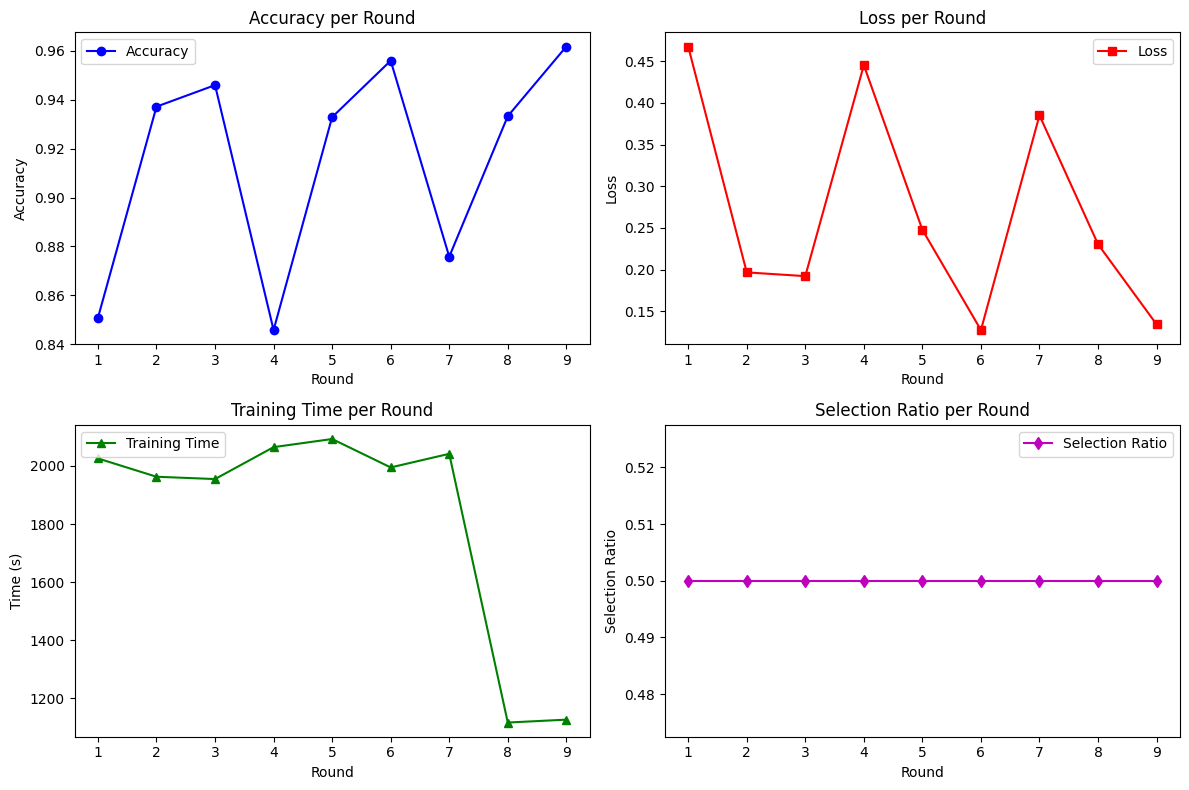

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

# ---------------- Performance Metrics Plotting ---------------- #
def plot_performance_metrics(performance_metrics, accuracies, losses, num_clients=2):
    rounds = [entry['round'] for entry in performance_metrics]
    training_times = [entry['training_time'] for entry in performance_metrics]
    selection_ratios = [len(entry['selected_clients']) / num_clients for entry in performance_metrics]

    fig, axs = plt.subplots(2, 2, figsize=(12, 8))

    axs[0, 0].plot(rounds, accuracies, marker='o', label='Accuracy', color='b')
    axs[0, 0].set_title("Accuracy per Round")
    axs[0, 0].set_xlabel("Round")
    axs[0, 0].set_ylabel("Accuracy")
    axs[0, 0].legend()

    axs[0, 1].plot(rounds, losses, marker='s', label='Loss', color='r')
    axs[0, 1].set_title("Loss per Round")
    axs[0, 1].set_xlabel("Round")
    axs[0, 1].set_ylabel("Loss")
    axs[0, 1].legend()

    axs[1, 0].plot(rounds, training_times, marker='^', label='Training Time', color='g')
    axs[1, 0].set_title("Training Time per Round")
    axs[1, 0].set_xlabel("Round")
    axs[1, 0].set_ylabel("Time (s)")
    axs[1, 0].legend()

    axs[1, 1].plot(rounds, selection_ratios, marker='d', label='Selection Ratio', color='m')
    axs[1, 1].set_title("Selection Ratio per Round")
    axs[1, 1].set_xlabel("Round")
    axs[1, 1].set_ylabel("Selection Ratio")
    axs[1, 1].legend()

    plt.tight_layout()
    plt.show()

# Updated Performance Metrics based on logs
performance_metrics = [
    {'round': 1, 'selected_clients': [1], 'training_time': 2026},
    {'round': 2, 'selected_clients': [0], 'training_time': 1963},
    {'round': 3, 'selected_clients': [1], 'training_time': 1955},
    {'round': 4, 'selected_clients': [0], 'training_time': 2065},
    {'round': 5, 'selected_clients': [1], 'training_time': 2093},
    {'round': 6, 'selected_clients': [0], 'training_time': 1995},
    {'round': 7, 'selected_clients': [1], 'training_time': 2042},
    {'round': 8, 'selected_clients': [0], 'training_time': 1116},
    {'round': 9, 'selected_clients': [1], 'training_time': 1126},
]

accuracies = [0.8508, 0.9372, 0.9460, 0.8458, 0.9329, 0.9560, 0.8758, 0.9333, 0.9618]
losses = [0.4677, 0.1966, 0.1921, 0.4453, 0.2477, 0.1274, 0.3851, 0.2304, 0.1342]

plot_performance_metrics(performance_metrics, accuracies, losses)

In [3]:
!pip install keras-preprocessing


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.5 MB/s eta 0:00:00
